# Sea surface fonditions

In [1]:
model_name1 = ""
model_name2 = "MIROC5-iso"
model_name=model_name2

import sys
sys.path.append("/data44/kanon/LGM_ensemble")
import exp_list
df_exp = exp_list.read_exp_name(model_name, model_name1=model_name1, model_name2=model_name2)


expname_ref, expname, expname4, expname2, expname3 = df_exp.columns.tolist()
exp_label_ref, exp_label, exp_label4, exp_label2, exp_label3= df_exp.T["label"].tolist()


exp_label_anom=exp_label+" - "+exp_label_ref
exp_label_ratio=exp_label+" / "+exp_label_ref

In [2]:
import warnings
warnings.simplefilter("ignore")
#
import os
#
import time
import datetime
import statsmodels.api as sm
import statsmodels.tools.eval_measures as smte
from cmocean import cm as cmo
import xarray as xr
import paramiko
import numpy as np
import pandas as pd
from netCDF4 import num2date
from netCDF4 import Dataset as NetCDFFile
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mc
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import matplotlib.path as mpath
from matplotlib.colors import Normalize
from mpl_toolkits.basemap import Basemap
%matplotlib inline
#
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as feature
#
from cdo import *
cdo=Cdo()
from gtool3 import gtopen

# Original functions
from command import command as cmd
from read_netcdf import *
from set_colormaps import get_color_code,  Color_Set 
import set_colormaps
import set_figure_params 
from set_colormaps import  get_color_code
# gtool3
## Installation: https://isotope.iis.u-tokyo.ac.jp/~kanon/src/gtool4python.html
from read_gtool import read_gtool
gt = read_gtool()
gtaxdir = cmd("echo $GTAXDIR")
print(gtaxdir)

/home/kanon/local/gt2gr/gt3


In [3]:
# 描画設定
plt.rcParams["axes.linewidth"] = 1        # グラフ囲う線の太さ
plt.rcParams["axes.grid"] = False         # グリッドを表示するかどうか
plt.rcParams["axes.axisbelow"] = True         # グリッドを背景に描く
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False,'pcolor.shading':'auto'})

In [4]:
class draw_map:
    import cartopy.crs as ccrs

    def label_h(self,fig,ax,barplot,cs,levels,label,fontsize):
        import matplotlib.pyplot as plt
        cbaCorrax = fig.add_axes(barplot)
        cbar=plt.colorbar(cs, cax=cbaCorrax,orientation='horizontal',ticks=levels) 
        cbar.ax.tick_params(labelsize=fontsize) 
        cbar.set_label(label, size=fontsize)
    
    
    def label_v(self,fig,ax,barplot,cs,levels,label,fontsize):
        import matplotlib.pyplot as plt
        cbaCorrax = fig.add_axes(barplot)
        cbar=plt.colorbar(cs, cax=cbaCorrax,orientation='vertical',ticks=levels) 
        cbar.ax.tick_params(labelsize=fontsize) 
        cbar.set_label(label, size=fontsize)

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# from matplotlib.colors import ListedColormap, BoundaryNorm #, rhb2hex

# def make_colorpalet(colorname="viridis",levels=[10,30,60,70,90]):
#     # https://hackmd.io/@h2tg95D2RP2ed-D8u-49Mg/S1moBqaRr
#     white="#ffffff"
#     lightcyan="#E0FFFF"
#     paleturquoise="#AFEEEE"
# #    color_code=[paleturquoise,lightcyan,white]
#     color_code=[paleturquoise,white]
#     num = len(levels)-len(color_code)+1
#     color_code.extend(get_color_code(colorname,num)[:])

#     # カラーマップ作成(→ 1)
#     cmap, norm = mc.from_levels_and_colors(levels,color_code,extend="both")
    
#     return cmap, norm 

# def get_color_code(cname,num):
#     cmap = cm.get_cmap(cname,num)

#     code_list =[]
#     for i in range(cmap.N):
#         rhb = cmap(i)[:3]
# #        print(rhb2ahex(rhb))
# #        code_list.append(rhb2hex(rhb))

#     return code_list

In [6]:
# Read axes of t42
filename = "clm/u"
xname = gtopen(expname+"/"+filename).vars["U"].header["AITM1"]
yname = gtopen(expname+"/"+filename).vars["U"].header["AITM2"]
zname = gtopen(expname+"/"+filename).vars["U"].header["AITM3"]
## Stores axes information
dlon = gtopen(gtaxdir+"/GTAXLOC."+xname).vars[xname][0,0,0,:]
dlat = gtopen(gtaxdir+"/GTAXLOC."+yname).vars[yname][0,0,0,:]
dlev = gtopen(gtaxdir+"/GTAXLOC."+zname).vars[zname][0,0,0,:]
# number of grids
nlon =len(dlon)
nlat = len(dlat)
nlev = len(dlev)

In [7]:
mm = np.arange(1,13,1)
mons = pd.DataFrame.from_dict({
    "Mon": mm,
    "days": [31,28,31,30,31,30,31,31,30,31,30,31],
    "DJF" : (mm==12)+(mm==1)+(mm==2),
    "MAM": (mm==3)+(mm==4)+(mm==5),
    "JJA":   (mm==6)+(mm==7)+(mm==8),
    "SON": (mm==9)+(mm==10)+(mm==11)

}, orient="columns")
mons.index = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

In [8]:
def label_h(fig, cs, barplot=[0.1, 0.01, 0.8, 0.05], levels=[0], 
            label="", fontsize=16, fontlabel=16):
    import matplotlib.pyplot as plt
    cbar_ax = fig.add_axes(barplot)
    if levels == [0]:
        cbar=plt.colorbar(cs, cax=cbar_ax,orientation='horizontal') 
    else:
        cbar=plt.colorbar(cs, cax=cbar_ax,orientation='horizontal',ticks=levels) 
    cbar.ax.tick_params(labelsize=fontsize) 
    cbar.set_label(label, size=fontlabel)

    return cbar

In [9]:
levels = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10]
cmapname = "coolwarm"
cmap, norm = Color_Set(levels, cmapname)
class draw_Ant:
    def raw(self,ax,area,title,x,y,var0,norm,cmap,levels,fontsize=24,cont=False, levelso=levels,var0o=[],mask=False):
        import cartopy.crs as ccrs
        ax.set_boundary(draw_Ant().circle(), transform=ax.transAxes)
        ax.set_title(title, fontsize=fontsize) 
        ax.coastlines()        
        cm = plt.get_cmap(cmap)
        cs = ax.contourf(x, y, var0, 
                             norm=norm, cmap=cmap, levels=levels, 
                             transform=ccrs.PlateCarree(),extend = "both")
        if cont == True:
            ax.contour(x, y, var0o, 
                       colors="black", levels=levelso, linewidth=0.1, alpha=0.5, transform=ccrs.PlateCarree())
        df_lon, df_lat,sx,sy = Site().DomeF()
        ax.scatter(df_lon,df_lat,c="black", s=200, 
                       marker='^', edgecolors='white', linewidth=2, zorder=10,transform=ccrs.PlateCarree())            
        ax.set_global()
        ax.set_extent(area, crs=ccrs.PlateCarree())
 
        return cs

    def stream(self,ax,area,title,x,y,varu,varv, minlen=np.nan, maxlen=np.nan):
        import cartopy.crs as ccrs
        ax.set_boundary(draw_Ant().circle(), transform=ax.transAxes)
        ax.set_title(title, fontsize=24) 
        
        cs = ax.streamplot(x, y, varu, varv, minlength=minlen, maxlength=maxlen, \
                               color=np.sqrt(varu**2+varv**2), cmap=plt.cm.jet, \
                               density=[1, 1], linewidth=1.5, arrowsize=2,\
                               transform=ccrs.PlateCarree())

        ax.set_global()
        ax.coastlines()
        ax.set_extent(area, crs=ccrs.PlateCarree())
 
        return cs   

    def circle(self):
        import numpy as np
        import matplotlib.path as mpath
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        
        return circle 

In [10]:
grlndf_LGM  = np.zeros((nlat,nlon))
grlndf_LGM[:,:-1] = gtopen("/data44/kanon/kino2023grl/grlndfglac1d.t42").vars["GRLNDF"][0,0,:,:]
grlndf_LGM[:,-1] = grlndf_LGM[:,0]
grlndf_LGM[grlndf_LGM<=0.01] = np.nan

In [11]:
mask_levels                     = [0.01,2,5]
mask_cmapname             = "Greys"
mask_cmap   ,mask_norm = Color_Set(mask_levels, mask_cmapname)

In [12]:
levels = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10]
cmapname = "coolwarm"
cmap, norm = Color_Set(levels, cmapname)

In [60]:
levels = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10]
cmapname = "coolwarm"
cmap, norm = Color_Set(levels, cmapname)
def drawglobal_field(var1,var1o=[],  title1="", 
                      label="", levels=levels, cmap=cmap, norm=norm, label_fontsize=16,
                     cont=False, levelso=levels, contlabels=False,
                     mask=False, maskfile=grlndf_LGM,
                     area=[-180,180,-90,90], cent_lon=0):
    
    if (area[-1]-area[-2]) >90:
        figsize=(7,4.5)
    else:
        figsize=(7,2)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize,
                                   subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=cent_lon)))
    
    ax.set_title(title1, loc="left", fontsize=20, weight="demibold")
    ax.coastlines() 
    
    cs = ax.contourf(dlon, dlat, var1, 
                norm=norm, cmap=cmap, levels=levels, extend="both",
                transform=ccrs.PlateCarree()) 
    if cont == True:
        cs2 = ax.contour(dlon, dlat, var1o, 
                       colors="black", levels=levelso, linewidth=0.1, alpha=0.5, transform=ccrs.PlateCarree()) 
        if contlabels == True:
            ax.clabel(cs2,cs2.levels,fmt="%3.1f") 
        elif contlabels == "integer":
            ax.clabel(cs2,cs2.levels,fmt="%3d") 
    if mask == True:
        ax.contourf(dlon,dlat,maskfile, 
                             norm=mask_norm,cmap=mask_cmap,levels=mask_levels,
                             transform=ccrs.PlateCarree(),extend = "both")
    ax.set_ylim(area[2:])
        
        
    if (area[-1]-area[-2]) >90:
        barplot=[0.04, 0.05, 0.9, 0.05]
        draw_map().label_h(fig, ax, barplot, cs, levels, label, label_fontsize)
        plt.subplots_adjust(top=0.95,bottom=0.05,left=0.02,right=0.98,hspace=0.05,wspace=0.05)
    else:
        barplot=[0.04, 0.05, 0.9, 0.1]
        draw_map().label_h(fig, ax, barplot, cs, levels, label, label_fontsize)
        plt.subplots_adjust(top=0.95,bottom=0.05,left=0.02,right=0.98,hspace=0.05,wspace=0.05)
    return fig, ax

In [14]:
def ice_meanlat(icein, mon, ice_thres=0.15):
    lat_list=np.zeros(nlon-1)
    for xx in range(nlon-1):
        num = np.abs(icein[mon-1,np.int(nlat/2):,xx]-ice_thres).arhmin()
        if num == 0:
            lat_list[xx] = np.nan
        else:
            lat_list[xx] = dlat[np.int(nlat/2)+num]
            
    return np.nanmean(lat_list)

In [15]:
def seaice(ax,dlon,dlat,var1,var2,levels=np.arange(0,1,0.1), mask=True, maskfile=grlndf_LGM):
    ax.contour(dlon,dlat, var1, colors="magenta", levels=levels, linewidths=2, linestyles="dashed", alpha=0.4,
               transform=ccrs.PlateCarree()) 
    ax.contour(dlon,dlat, var2, colors="green"      , levels=levels, linewidths=2, linestyles="dashed", alpha=0.4,
               transform=ccrs.PlateCarree()) 
    if mask == True:
        ax.contourf(dlon,dlat,maskfile,
                             norm=mask_norm,cmap=mask_cmap,levels=mask_levels,
                             transform=ccrs.PlateCarree(),extend = "both")
    return ax

In [16]:
filename = "clm/gricr"
ice = gtopen(expname+"/"+filename).vars["GRICR"][:,0,:,:] 
iceseas = np.zeros((5, nlat,nlon))
iceseas[0,:,:-1] = np.nanmean(ice[mons["DJF"]==True,:,:],0)
iceseas[1,:,:-1] = np.nanmean(ice[mons["MAM"]==True,:,:],0)
iceseas[2,:,:-1] = np.nanmean(ice[mons["JJA"]==True,:,:],0)
iceseas[3,:,:-1] = np.nanmean(ice[mons["SON"]==True,:,:],0)
iceseas[4,:,:-1] = np.nanmean(ice,0) # Annual
iceseas[:,:,-1] = iceseas[:,:,0]

iceseas[:,grlndf_LGM>=1]= np.nan

In [17]:
filename = "clm/gricr"
ice = gtopen(expname2+"/"+filename).vars["GRICR"][:,0,:,:] 
iceseas2 = np.zeros((5, nlat,nlon))
iceseas2[0,:,:-1] = np.nanmean(ice[mons["DJF"]==True,:,:],0)
iceseas2[1,:,:-1] = np.nanmean(ice[mons["MAM"]==True,:,:],0)
iceseas2[2,:,:-1] = np.nanmean(ice[mons["JJA"]==True,:,:],0)
iceseas2[3,:,:-1] = np.nanmean(ice[mons["SON"]==True,:,:],0)
iceseas2[4,:,:-1] = np.nanmean(ice,0) # Annual
iceseas2[:,:,-1] = iceseas2[:,:,0]

iceseas2[:,grlndf_LGM>=1]= np.nan

In [18]:
filename = "clm/gricr"
ice = gtopen(expname_ref+"/"+filename).vars["GRICR"][:,0,:,:]
#ice[ice<=0.001] = np.nan
iceseas_ref = np.zeros((5, nlat,nlon))
iceseas_ref[0,:,:-1] = np.nanmean(ice[mons["DJF"]==True,:,:],0)
iceseas_ref[1,:,:-1] = np.nanmean(ice[mons["MAM"]==True,:,:],0)
iceseas_ref[2,:,:-1] = np.nanmean(ice[mons["JJA"]==True,:,:],0)
iceseas_ref[3,:,:-1] = np.nanmean(ice[mons["SON"]==True,:,:],0)
iceseas_ref[4,:,:-1] = np.nanmean(ice,0) # Annual
iceseas_ref[:,:,-1] = iceseas_ref[:,:,0]

iceseas_ref[:,grlndf_LGM>=1]= np.nan

In [19]:
ice_levels = [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
ice_cmapname = "Blues_r"
ice_cmap, ice_norm = Color_Set(ice_levels, ice_cmapname)
ice_label = "Sea Ice Concentration"
ice_unit = "[-]" 

In [20]:
filename = "clm/grsst"
sst = gtopen(expname+"/"+filename).vars["GRSST"][:,0,:,:] - 273.15
sstseas = np.zeros((5, nlat,nlon))
sstseas[0,:,:-1] = np.nanmean(sst[mons["DJF"]==True,:,:],0)
sstseas[1,:,:-1] = np.nanmean(sst[mons["MAM"]==True,:,:],0)
sstseas[2,:,:-1] = np.nanmean(sst[mons["JJA"]==True,:,:],0)
sstseas[3,:,:-1] = np.nanmean(sst[mons["SON"]==True,:,:],0)
sstseas[4,:,:-1] = np.nanmean(sst,0) # Annual
sstseas[:,:,-1] = sstseas[:,:,0]

for ss in range(5):
    sstseas[:,iceseas[ss,:,:]>0.99]= np.nan

In [21]:
filename = "clm/grsst"
sst = gtopen(expname2+"/"+filename).vars["GRSST"][:,0,:,:] - 273.15
sstseas2 = np.zeros((5, nlat,nlon))
sstseas2[0,:,:-1] = np.nanmean(sst[mons["DJF"]==True,:,:],0)
sstseas2[1,:,:-1] = np.nanmean(sst[mons["MAM"]==True,:,:],0)
sstseas2[2,:,:-1] = np.nanmean(sst[mons["JJA"]==True,:,:],0)
sstseas2[3,:,:-1] = np.nanmean(sst[mons["SON"]==True,:,:],0)
sstseas2[4,:,:-1] = np.nanmean(sst,0) # Annual
sstseas2[:,:,-1] = sstseas2[:,:,0]

for ss in range(5):
    sstseas2[:,iceseas2[ss,:,:]>0.99]= np.nan

In [22]:
filename = "clm/grsst"
sst = gtopen(expname_ref+"/"+filename).vars["GRSST"][:,0,:,:] - 273.15
sstseas_ref = np.zeros((5, nlat,nlon))
sstseas_ref[0,:,:-1] = np.nanmean(sst[mons["DJF"]==True,:,:],0)
sstseas_ref[1,:,:-1] = np.nanmean(sst[mons["MAM"]==True,:,:],0)
sstseas_ref[2,:,:-1] = np.nanmean(sst[mons["JJA"]==True,:,:],0)
sstseas_ref[3,:,:-1] = np.nanmean(sst[mons["SON"]==True,:,:],0)
sstseas_ref[4,:,:-1] = np.nanmean(sst,0) # Annual
sstseas_ref[:,:,-1] = sstseas_ref[:,:,0]

for ss in range(5):
    sstseas_ref[:,iceseas_ref[ss,:,:]>0.99]= np.nan

In [23]:
ssta_levels = [-10,-6,-4,-3,-2,-0.5,0.5,2,3,4,6,10]
ssta_cmapname        = "RdBu_r"
ssta_cmap, ssta_norm = Color_Set(ssta_levels, ssta_cmapname)
ssta_label = "Sea Surface Temperature Anomaly"
ssta_unit = "[$\mathrm{^\circ C}$]" 

In [24]:
sst_levels = [0, 2, 3,4,6, 10, 12, 15, 18, 21, 25, 30, 35]
sst_cmapname        = "RdBu_r"
sst_cmap, sst_norm = Color_Set(sst_levels, sst_cmapname)
sst_label = "Sea Surface Temperature"
sst_unit = "[$\mathrm{^\circ C}$]" 

## LGM_G - PI

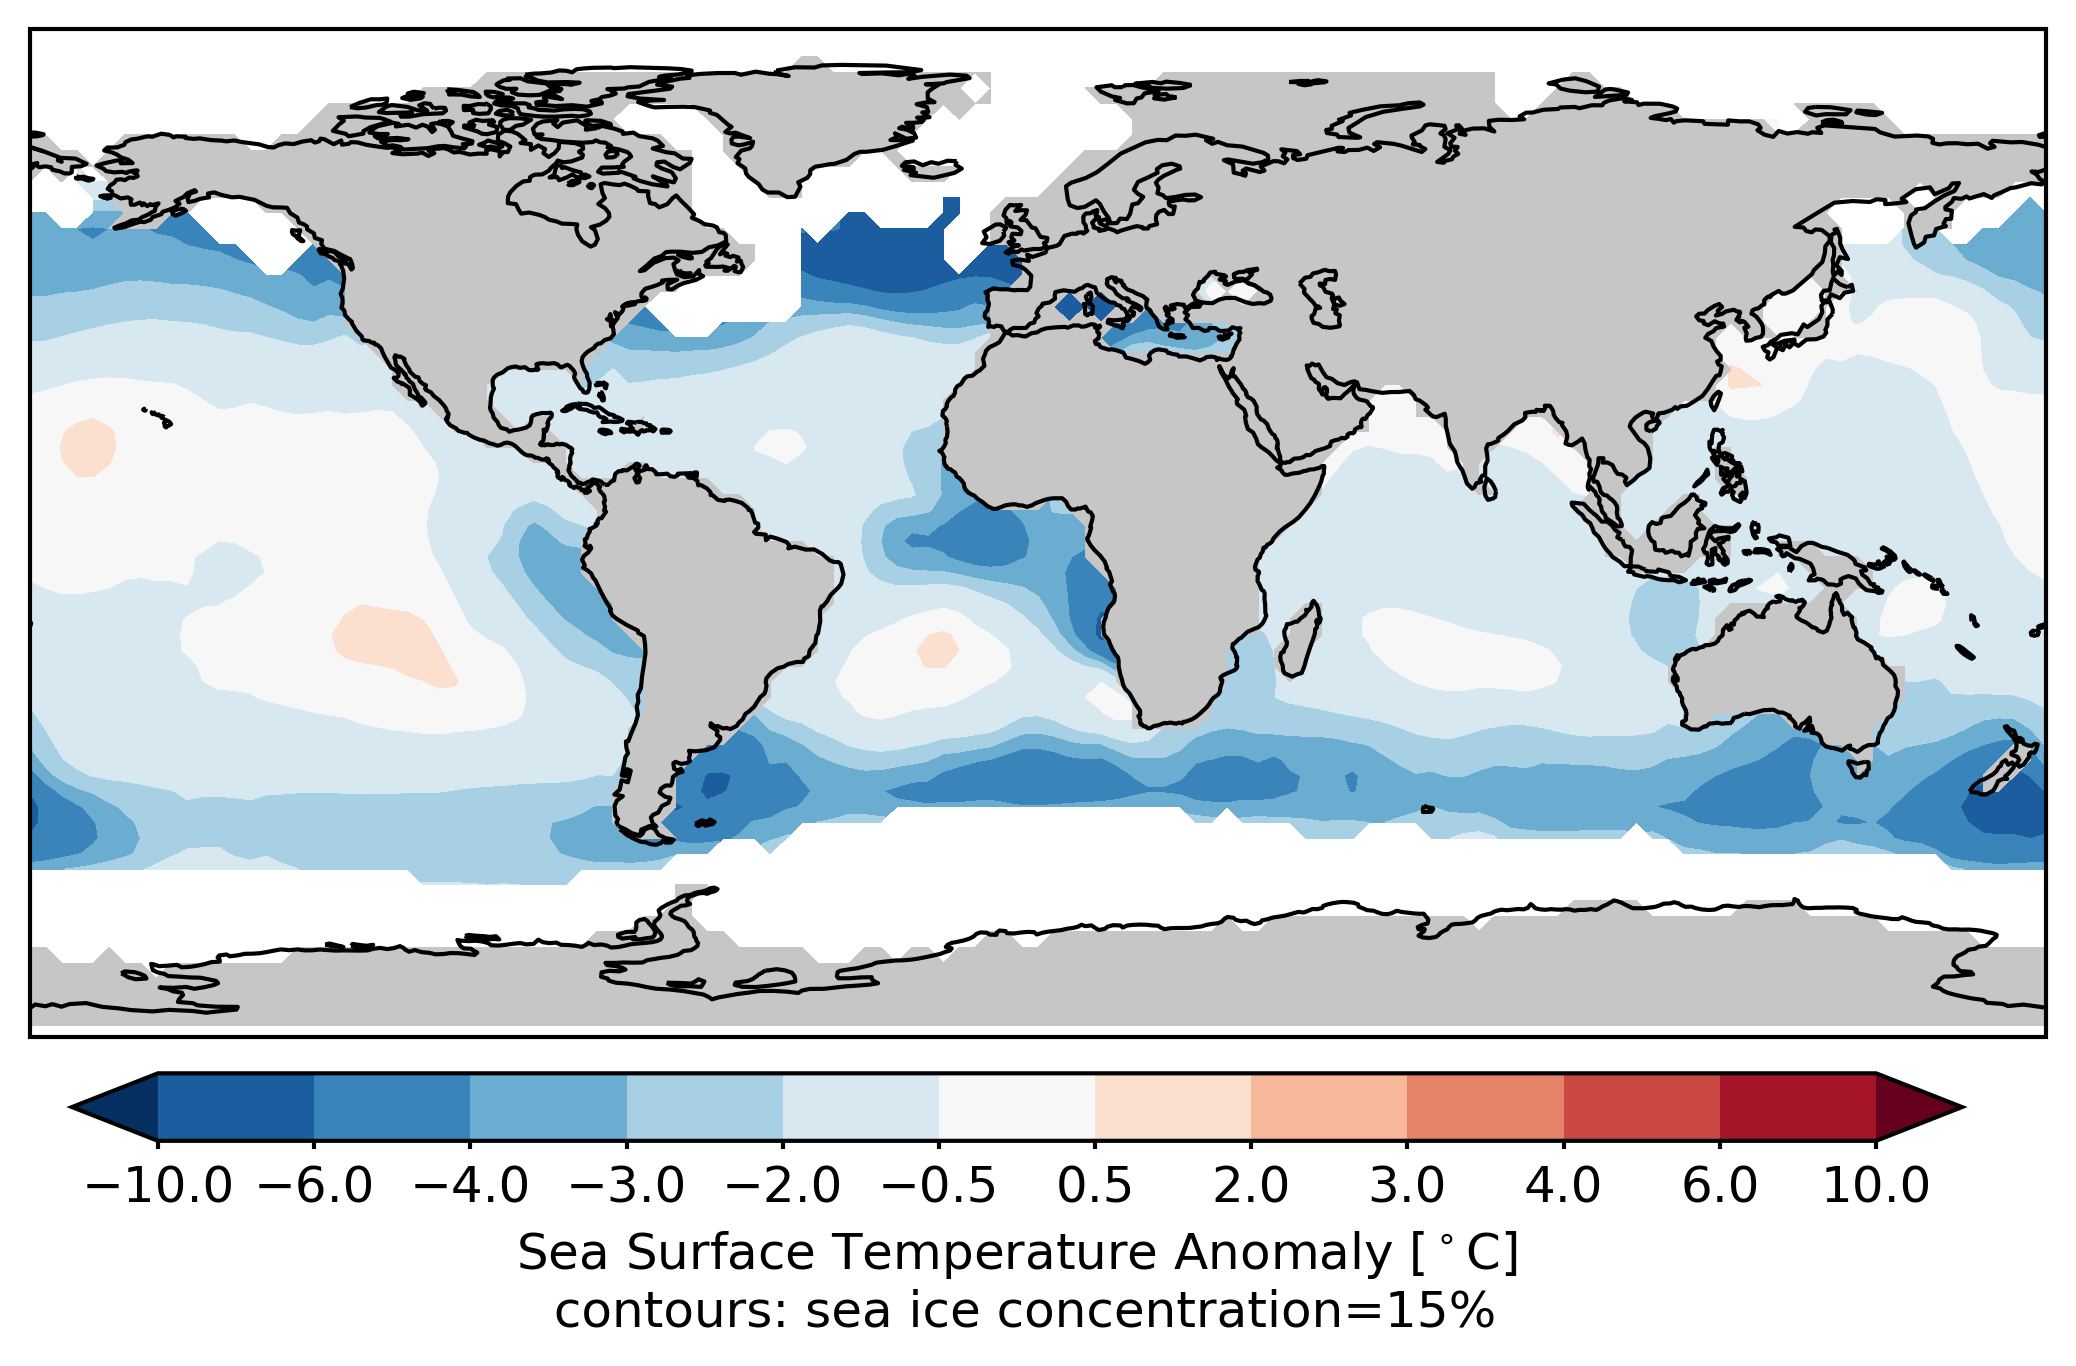

In [33]:
fig,ax = drawglobal_field(sstseas[4,:,:]-sstseas_ref[4,:,:], sstseas_ref[4,:,:],
                          title1="",  area=[-180,180,-90,90],
                           label=ssta_label+" "+ssta_unit+"\n contours: sea ice concentration=15%",
                           levels=ssta_levels, cmap=ssta_cmap, norm=ssta_norm,
                           mask=True,label_fontsize=12)

fig.show()

## LGM_M - PI

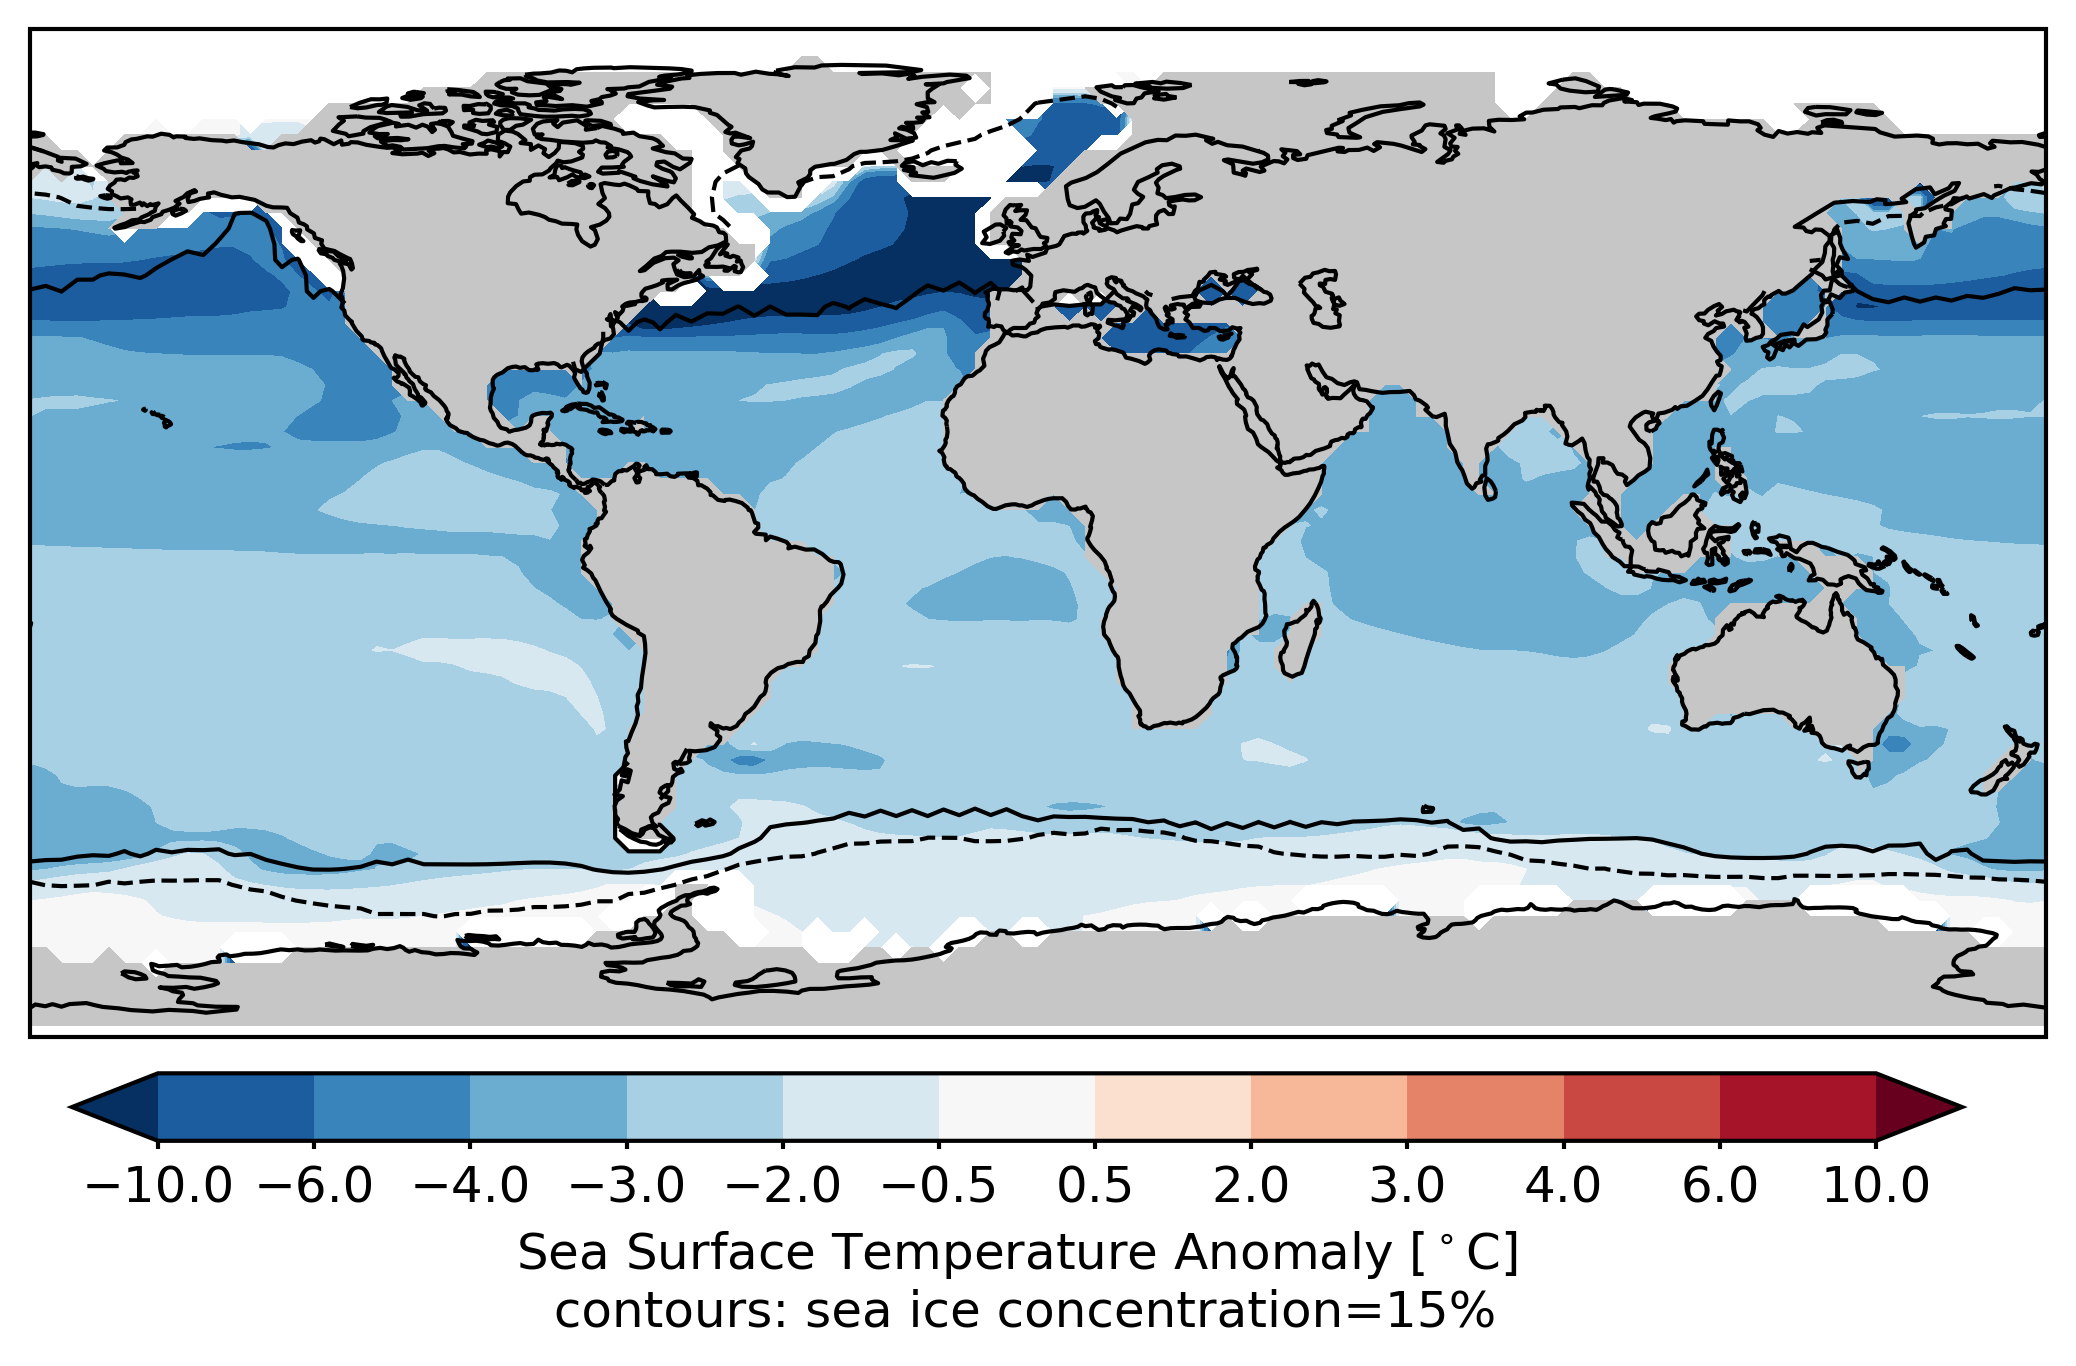

In [48]:

fig,ax = drawglobal_field(sstseas2[4,:,:]-sstseas_ref[4,:,:], sstseas_ref[4,:,:],
                          title1="",  area=[-180,180,-90,90],
                           label=ssta_label+" "+ssta_unit+"\n contours: sea ice concentration=15%",
                           levels=ssta_levels, cmap=ssta_cmap, norm=ssta_norm,
                           mask=True,label_fontsize=12)
ax.contour(dlon, dlat, iceseas2[4,:,:]*100, 
              colors="black", levels=[15],  linewidths=1, linestyles="solid",
              transform=ccrs.PlateCarree()) 
ax.contour(dlon, dlat, iceseas_ref[4,:,:]*100, 
              colors="black", levels=[15],  linewidths=1, linestyles="dashed",
              transform=ccrs.PlateCarree()) 
fig.show()